In [1]:
from openff.evaluator import unit as openff_unit
from openff.evaluator.datasets import PhysicalProperty

In [2]:
energy_unit = openff_unit.kcal / openff_unit.mole

### Get experiment data for test set

In [3]:
test_data = PhysicalProperty.from_json("original/test_set.json")

experiment = {}
for prop in test_data.properties:
    guest_name = (
        prop.metadata["guest_file_paths"]["guest_mol2_path"]
        .split("/")[-1]
        .split(".")[0]
    )
    experiment[guest_name] = {
        "value": prop.value.to(energy_unit).magnitude,
        "uncertainty": prop.uncertainty.to(energy_unit).magnitude,
    }

experiment

{'m4c': {'value': -4.318833652007648, 'uncertainty': 0.0059751434034416824},
 'ben': {'value': -1.6395793499043978, 'uncertainty': 0.02390057361376673},
 'cbu': {'value': -1.5535372848948374, 'uncertainty': 0.1673040152963671}}

### Extract calculated results

In [4]:
def extract_results(json_file):
    with open(json_file, "r") as f:
        results = json.load(f)

    calculated = {}
    for prop in results["estimated_properties"]["properties"]:
        guest_name = (
            prop["metadata"]["guest_file_paths"]["guest_mol2_path"]
            .split("/")[-1]
            .split(".")[0]
        )
        calculated[guest_name] = {
            "value": openff_unit.Quantity(
                prop["value"]["value"],
                units=prop["value"]["unit"],
            )
            .to(energy_unit)
            .magnitude,
            "uncertainty": openff_unit.Quantity(
                prop["uncertainty"]["value"],
                units=prop["uncertainty"]["unit"],
            )
            .to(energy_unit)
            .magnitude,
        }

    return calculated

In [5]:
calc_original = extract_results("original/results.json")
calc_optimized = extract_results("optimized/results.json")

In [6]:
calc_original

{'m4c': {'value': -7.776039509653752, 'uncertainty': 0.5631910878172937},
 'ben': {'value': -1.8090953397231002, 'uncertainty': 0.5675474788593864},
 'cbu': {'value': -5.3560943284260265, 'uncertainty': 0.5453597724234057}}

In [7]:
calc_optimized

{'m4c': {'value': -4.510727072247038, 'uncertainty': 0.5012388630111474},
 'ben': {'value': -2.714262147004421, 'uncertainty': 0.4968305272555053},
 'cbu': {'value': -2.6662243575070486, 'uncertainty': 0.4934169705427141}}

### Get statistics

In [8]:
from bootstrap import bootstrap

In [9]:
# Collect all experiment value in "x" and calculated value in "y"
x_val = []
x_sem = []
y_val_original = []
y_sem_original = []
y_val_optimized = []
y_sem_optimized = []
for guest in experiment:
    x_val.append(experiment[guest]["value"])
    x_sem.append(experiment[guest]["uncertainty"])

    # Original
    y_val_original.append(calc_original[guest]["value"])
    y_sem_original.append(calc_original[guest]["uncertainty"])

    # Optimized
    y_val_optimized.append(calc_optimized[guest]["value"])
    y_sem_optimized.append(calc_optimized[guest]["uncertainty"])

# Calculate statistics
stats_original = bootstrap(
    x=x_val, x_sem=x_sem, y=y_val_original, y_sem=y_sem_original, cycles=10000
)
stats_optimized = bootstrap(
    x=x_val, x_sem=x_sem, y=y_val_optimized, y_sem=y_sem_optimized, cycles=10000
)

### Plot comparison

In [10]:
import matplotlib.pyplot as plt

In [11]:
def plot_results(
    statistics,
    x_data,
    y_data,
    lmin=-8,
    lmax=2,
):
    fig, ax = plt.subplots(1, figsize=(6 * 1.0, 6))

    # Plot calc vs expt
    ax.scatter(x_data, y_data, color="r", s=100)

    # Plot statistics on top left of plot
    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['ci_low']['RMSE']:0.2f}, {statistics['ci_high']['RMSE']:0.2f}]"
    text += "\n"
    text += f"R$^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['ci_low']['R**2']:0.2f}, {statistics['ci_high']['R**2']:0.2f}]"
    left, width = 0.25, 0.5
    bottom, height = 0.25, 0.5
    right = left + width
    top = bottom + height
    ax.annotate(
        text,
        (0.01, 0.99),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        horizontalalignment="left",
        verticalalignment="top",
        size=13,
        backgroundcolor="white",
        transform=ax.transAxes,
    )

    # Plot x = y line
    ax.plot([lmin, lmax], [lmin, lmax], "-", color="gray", linewidth=1)
    ax.set_xlabel("Expt" + r" $\Delta$G (kcal/mol)", fontsize=18)
    ax.set_ylabel("Calc" + r" $\Delta$G (kcal/mol)", fontsize=18)

    # Plot misc
    ax.set_ylim(lmin, lmax)
    ax.set_xlim(lmin, lmax)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.grid()

Text(0.5, 1.0, 'Original OBC1 GB Radius')

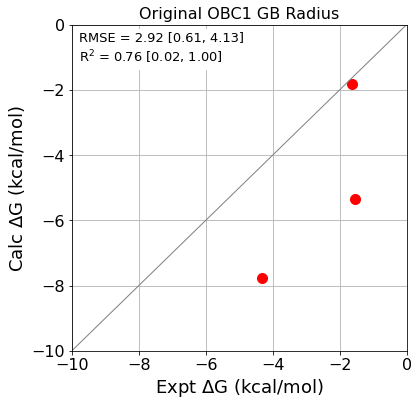

In [12]:
plot_results(
    stats_original,
    x_val,
    y_val_original,
    lmin=-10,
    lmax=0,
)
plt.title("Original OBC1 GB Radius", fontsize=16)

Text(0.5, 1.0, 'Optimized OBC1 GB Radius')

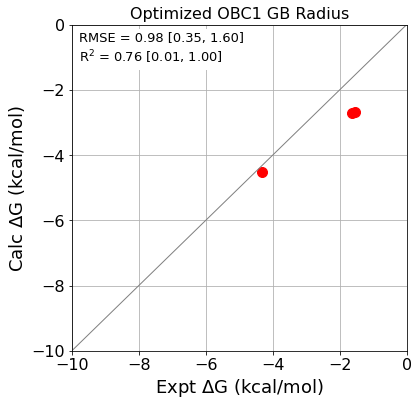

In [13]:
plot_results(
    stats_optimized,
    x_val,
    y_val_optimized,
    lmin=-10,
    lmax=0,
)
plt.title("Optimized OBC1 GB Radius", fontsize=16)